Plotting transformed images for class: Powdery mildew
Plotting transformed images for class: Healthy
Plotting transformed images for class: Cotton Boll Rot
Plotting transformed images for class: Bacterial blight
Plotting transformed images for class: Aphids


C:\Users\RoopaGanesh\anaconda3\envs\GG_1392\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\RoopaGanesh\anaconda3\envs\GG_1392\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - Loss: 1.2021 Acc: 0.5445
Epoch 2/10 - Loss: 0.7071 Acc: 0.7743
Epoch 3/10 - Loss: 0.5867 Acc: 0.8175
Epoch 4/10 - Loss: 0.5160 Acc: 0.8310
Epoch 5/10 - Loss: 0.4761 Acc: 0.8445
Epoch 6/10 - Loss: 0.4512 Acc: 0.8637
Epoch 7/10 - Loss: 0.4237 Acc: 0.8644
Epoch 8/10 - Loss: 0.4071 Acc: 0.8627
Epoch 9/10 - Loss: 0.3848 Acc: 0.8728
Epoch 10/10 - Loss: 0.3806 Acc: 0.8726


C:\Users\RoopaGanesh\anaconda3\envs\GG_1392\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The image is classified as class: Bacterial blight


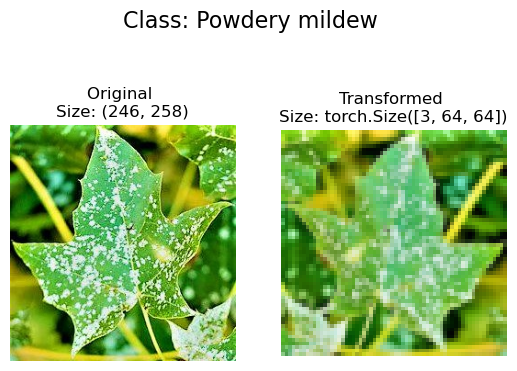

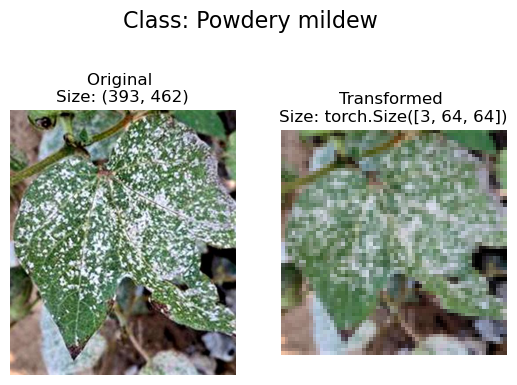

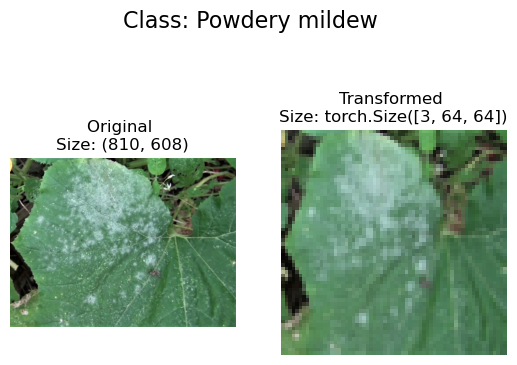

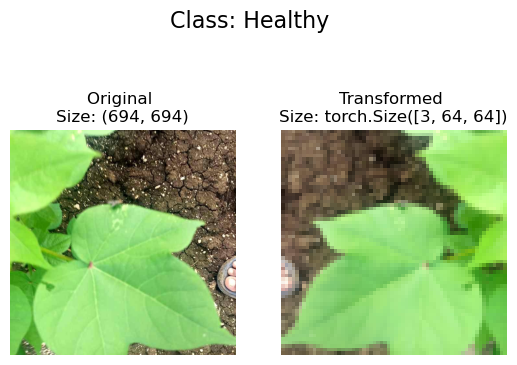

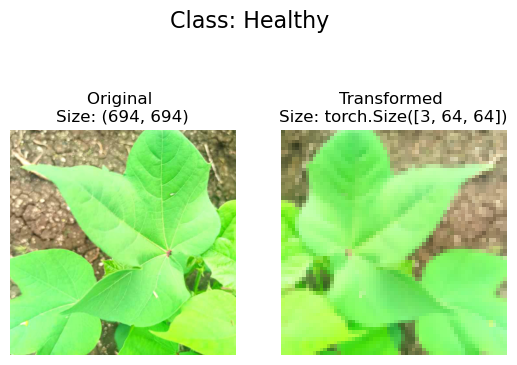

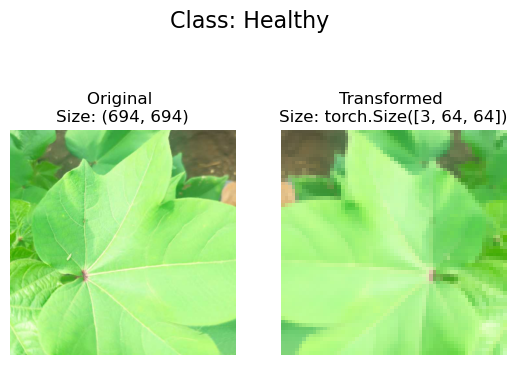

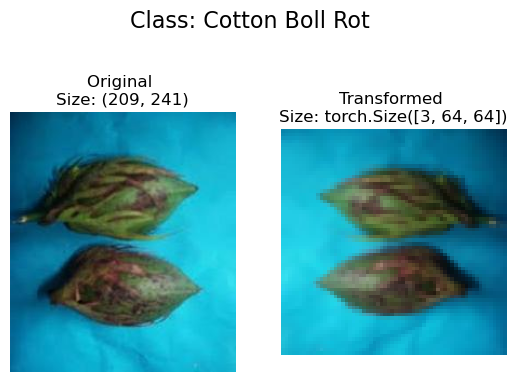

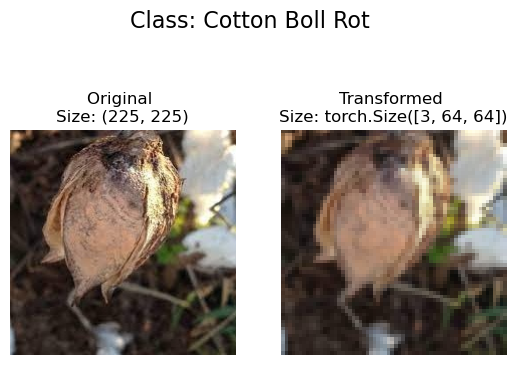

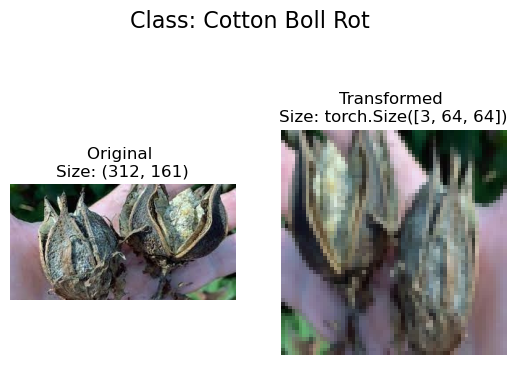

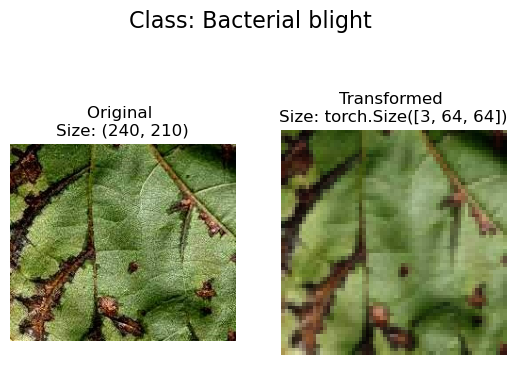

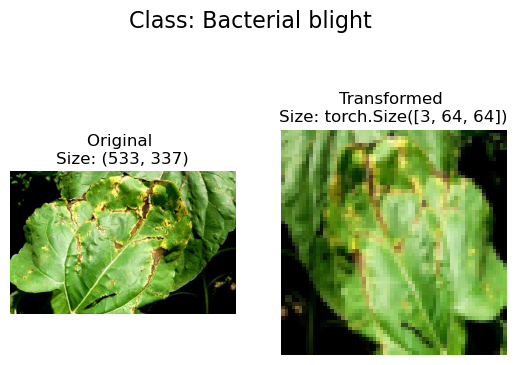

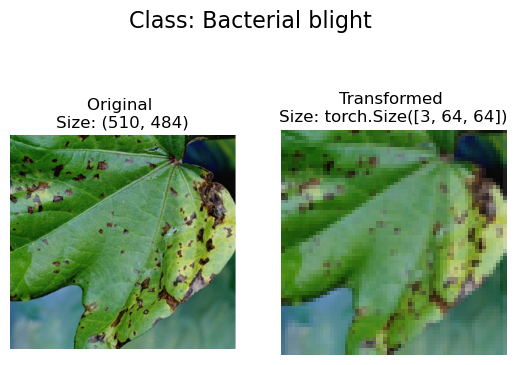

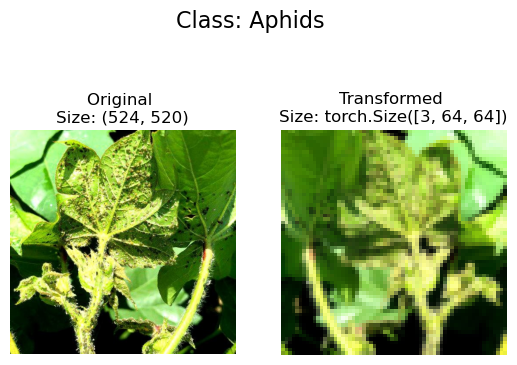

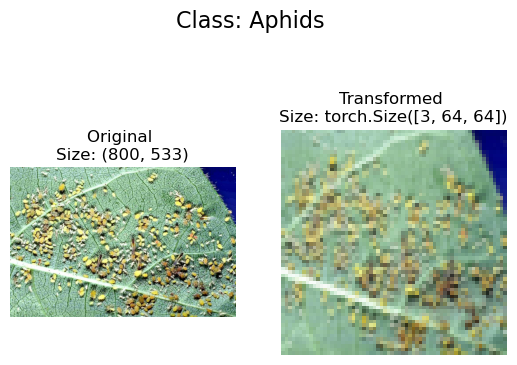

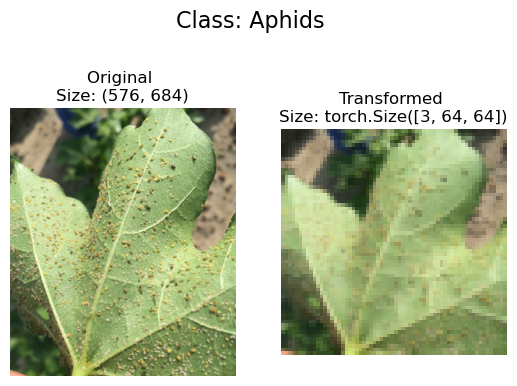

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as img:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(img)
            ax[0].set_title(f"Original \nSize: {img.size}")
            ax[0].axis("off")

            transformed_image = transform(img)
            ax[1].imshow(transformed_image.permute(1, 2, 0))
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            class_name = os.path.basename(os.path.dirname(image_path))
            fig.suptitle(f"Class: {class_name}", fontsize=16)

data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])


main_folder = "C:\\Users\\RoopaGanesh\\Downloads\\Cotton leaves - Training\\800 Images"

classes = ["Powdery mildew", "Healthy", "Cotton Boll Rot", "Bacterial blight", "Aphids"]
class_to_idx = {cls: i for i, cls in enumerate(classes)}


class_images = {cls: [] for cls in classes}


for cls in classes:
    class_folder = os.path.join(main_folder, cls)
    for filename in os.listdir(class_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(class_folder, filename)
            class_images[cls].append(img_path)


image_path_list = {cls: images for cls, images in class_images.items()}

for cls in classes:
    print(f"Plotting transformed images for class: {cls}")
    plot_transformed_images(image_path_list[cls], transform=data_transform, n=3)

train_data = datasets.ImageFolder(root=main_folder, transform=data_transform)
class_names = train_data.classes


train_dataloader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc.requires_grad = True
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    corrects = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_data)
    epoch_acc = corrects.double() / len(train_data)

    print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

# Save the fine-tuned model( with the weights that we want)
torch.save(model.state_dict(), "first_tuned_model_cotton_disease.pth")

# Testing phase
test_image_path = "C:\\Users\\RoopaGanesh\\Downloads\\Cotton leaves - Training\\11.jpg"
test_image = Image.open(test_image_path)

data_transform_test = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

transformed_test_image = data_transform_test(test_image)
transformed_test_image = transformed_test_image.unsqueeze(0)

model_test = models.resnet18(pretrained=False)
model_test.fc = nn.Linear(model_test.fc.in_features, len(class_names))
model_test.load_state_dict(torch.load("first_tuned_model_cotton_disease.pth"))
model_test.eval()
transformed_test_image = transformed_test_image.to(device)
model_test = model_test.to(device)

with torch.no_grad():
    outputs_test = model_test(transformed_test_image)
    _, predicted_test = torch.max(outputs_test, 1)

predicted_class_test = class_names[predicted_test.item()]
print(f"The image is classified as class: {predicted_class_test}")